# Data Pre-Processing

## Data Loading
- **File Reading:** Load signal files from the specified directories for healthy and patient groups
- **Label Assignment:** Assign a numerical label to each file based on its category (healthy or patient) for supervised learning.

In [1]:
# Cell 1: Imports and Setup (Updated channel names)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

pd.set_option('display.max_columns', None)

# Base paths configuration
base_paths = {
    "healthy": r"C:\NewHandPD\Healthy Signals\Signal",
    "patient": r"C:\NewHandPD\Patient Signals\Signal"
}

category_labels = {
    "healthy": 0,
    "patient": 1
}

# Updated channel names (excluding Microphone)
channel_names = [
    "Fingergrip", "Axial_Pressure",
    "Tilt_X", "Tilt_Y", "Tilt_Z"
]

## Data Parsing
- **Metadata Extraction:** Extract relevant metadata from each file, such as subject information and recording parameters, to enrich the dataset.
- **Signal Processing:** Parse and structure the signal data, dropping unnecessary channels (e.g., Microphone) and keeping only the relevant sensor channels.

In [2]:
# Cell 2: Enhanced File Parsing Function with Metadata Extraction
def parse_signal_file(file_path, label):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    meta_info = {}
    signal_start_idx = 0
    in_meta_section = False

    # Extract metadata
    for i, line in enumerate(lines):
        line = line.strip()
        
        if line == "#<meta>":
            in_meta_section = True
            continue
        elif line == "#</meta>":
            in_meta_section = False
            signal_start_idx = i + 1
            break
            
        if in_meta_section and line.startswith("#<") and line.endswith(">"):
            # Extract key-value pairs from metadata
            try:
                key = line[2:line.find(">")]  # Get text between #< and >
                value = line[line.find(">")+1:-1]  # Get text between > and <
                
                # Convert numeric values to appropriate type
                if value.isdigit():
                    value = int(value)
                elif value.replace('.', '', 1).isdigit():
                    value = float(value)
                elif value.lower() == 'true':
                    value = True
                elif value.lower() == 'false':
                    value = False
                elif value == '':
                    value = None
                    
                meta_info[key] = value
            except:
                continue

    # Load signal data and drop first channel (Microphone)
    signal_lines = lines[signal_start_idx:]
    signal_array = np.loadtxt(signal_lines, delimiter="\t")
    
    # Keep only channels 1-5 (drop channel 0 - Microphone)
    if signal_array.ndim == 1:
        signal_array = signal_array[1:6].reshape(1, -1)  # For single-row signals
    else:
        signal_array = signal_array[:, 1:6]  # For multi-row signals

    return signal_array, label, meta_info

In [3]:
# Cell 3: Main Processing (Now includes metadata in records)
all_records = []
sigMea_records = []
sigSp_records = []

for category, folder_path in base_paths.items():
    label = category_labels[category]
    print(f"Processing {category} files...")

    for file_name in tqdm(os.listdir(folder_path)):
        if not file_name.endswith(".txt"):
            continue
            
        file_path = os.path.join(folder_path, file_name)
        try:
            signal_data, label_val, meta_info = parse_signal_file(file_path, label)

            record = {
                "file_name": file_name,
                "label": label_val,
                "signal": signal_data,
                **meta_info  # Unpack all metadata into the record
            }

            all_records.append(record)
            
            # Filter for specific file prefixes
            if file_name.startswith("sigMea"):
                sigMea_records.append(record)
            elif file_name.startswith("sigSp"):
                sigSp_records.append(record)

        except Exception as e:
            print(f"Error parsing {file_name}: {e}")

Processing healthy files...


  0%|          | 0/421 [00:00<?, ?it/s]

100%|██████████| 421/421 [00:08<00:00, 47.42it/s]


Processing patient files...


100%|██████████| 373/373 [00:11<00:00, 31.77it/s]


In [4]:
# Cell 4: Create DataFrames (Now includes metadata columns)
df_all = pd.DataFrame(all_records)
df_sigMea = pd.DataFrame(sigMea_records)
df_sigSp = pd.DataFrame(sigSp_records)

print(f"\nSummary:")
print(f"Total files processed: {len(all_records)}")
print(f"Files starting with 'sigMea': {len(sigMea_records)}")
print(f"Files starting with 'sigSp': {len(sigSp_records)}")

# Show metadata columns we've extracted
print("\nMetadata columns found:")
print([col for col in df_all.columns if col not in ['file_name', 'label', 'signal']])


Summary:
Total files processed: 792
Files starting with 'sigMea': 264
Files starting with 'sigSp': 264

Metadata columns found:
['Person_ID_Number', 'Age', 'Gender', 'Writing_Hand', 'Weight', 'Height', 'Smoker', 'Notice', 'Object', 'Object_Index', 'Pen', 'Samplerate', 'Time', 'Date', 'Comment', 'Surename', 'Forename']


In [5]:
# Cell 4.1: Keep only the core metadata columns

core_cols = ['file_name', 'label', 'signal', 'Person_ID_Number', 'Age', 'Gender', 'Writing_Hand']

def select_existing_cols(df, cols):
    existing_cols = [col for col in cols if col in df.columns]
    return df[existing_cols]

df_all = select_existing_cols(df_all, core_cols)
df_sigMea = select_existing_cols(df_sigMea, core_cols)
df_sigSp = select_existing_cols(df_sigSp, core_cols)

## Data Cleaning
- **Missing and Outlier Data Handling:** Remove records with missing values or impossible signal values (e.g., negative physical measurements) to ensure data quality.
- **Signal Normalization:** Apply min-max scaling to each signal channel so all features are on a comparable scale, improving model performance and interpretability.

In [6]:
# Cell 5: Data Cleaning for DataFrames
# Remove rows with missing or NaN values in key columns
df_all_clean = df_all.dropna(subset=['signal', 'label', 'file_name'])
df_sigMea_clean = df_sigMea.dropna(subset=['signal', 'label', 'file_name'])
df_sigSp_clean = df_sigSp.dropna(subset=['signal', 'label', 'file_name'])

# Remove rows with impossible values (e.g., negative values for physical signals)
def remove_impossible_values(df):
    # Example: Remove rows where any signal value is negative
    mask = df['signal'].apply(lambda x: np.all(x >= 0))
    return df[mask]

df_all_clean = remove_impossible_values(df_all_clean)
df_sigMea_clean = remove_impossible_values(df_sigMea_clean)
df_sigSp_clean = remove_impossible_values(df_sigSp_clean)

# Normalize signal data (min-max scaling per sample)
def normalize_signal(signal):
    min_val = np.min(signal, axis=0)
    max_val = np.max(signal, axis=0)
    # Avoid division by zero
    denom = np.where(max_val - min_val == 0, 1, max_val - min_val)
    return (signal - min_val) / denom

df_all_clean['signal'] = df_all_clean['signal'].apply(normalize_signal)
df_sigMea_clean['signal'] = df_sigMea_clean['signal'].apply(normalize_signal)
df_sigSp_clean['signal'] = df_sigSp_clean['signal'].apply(normalize_signal)

print('Data cleaning complete:')
print(f'df_all_clean shape: {df_all_clean.shape}')
print(f'df_sigMea_clean shape: {df_sigMea_clean.shape}')
print(f'df_sigSp_clean shape: {df_sigSp_clean.shape}')

# Check for missing values in each DataFrame
print("\nMissing values in df_all_clean:", df_all_clean.isna().sum().sum())
print("Missing values in df_sigMea_clean:", df_sigMea_clean.isna().sum().sum())
print("Missing values in df_sigSp_clean:", df_sigSp_clean.isna().sum().sum())

# To see which columns have missing values:
print("\nColumns with missing values in df_all_clean:")
print(df_all_clean.isna().sum()[df_all_clean.isna().sum() > 0])

print("\nColumns with missing values in df_sigMea_clean:")
print(df_sigMea_clean.isna().sum()[df_sigMea_clean.isna().sum() > 0])

print("\nColumns with missing values in df_sigSp_clean:")
print(df_sigSp_clean.isna().sum()[df_sigSp_clean.isna().sum() > 0])

Data cleaning complete:
df_all_clean shape: (789, 7)
df_sigMea_clean shape: (262, 7)
df_sigSp_clean shape: (263, 7)

Missing values in df_all_clean: 0
Missing values in df_sigMea_clean: 0
Missing values in df_sigSp_clean: 0

Columns with missing values in df_all_clean:
Series([], dtype: int64)

Columns with missing values in df_sigMea_clean:
Series([], dtype: int64)

Columns with missing values in df_sigSp_clean:
Series([], dtype: int64)


# Data Splitting
- **Person-Based Splitting:** Divide the dataset into training, validation, and test sets based on unique person identifiers to prevent data leakage and ensure fair evaluation.
- **Randomization:** Shuffle person IDs before splitting to ensure unbiased distribution across splits.
- **Split Proportions:** Assign approximately 70% of persons to training, 15% to validation, and 15% to test sets for balanced model development and assessment.
- **Leakage Check:** Verify that no person appears in more than one split to maintain strict separation between training and evaluation data."

In [7]:
# Cell 6: Combine sigMea and sigSp DataFrames
df_combined = pd.concat([df_sigMea_clean, df_sigSp_clean], ignore_index=True)
print(f"Combined DataFrame shape: {df_combined.shape}")

Combined DataFrame shape: (525, 7)


In [8]:
# Cell 6.1: Split data by Person_ID_Number
import numpy as np

# Extract unique Person IDs
person_ids = df_combined['Person_ID_Number'].unique()

# Random shuffle of Person IDs
np.random.seed(42) # for reproducibility
np.random.shuffle(person_ids)

# Calculate split indices
train_split_ratio = 0.8
n_ids = len(person_ids)
train_idx = int(train_split_ratio * n_ids)

# Split Person IDs into train and test sets
train_ids = person_ids[:train_idx]
test_ids = person_ids[train_idx:]

# Create DataFrames for each split
df_train = df_combined[df_combined['Person_ID_Number'].isin(train_ids)]
df_test = df_combined[df_combined['Person_ID_Number'].isin(test_ids)]

print("\nData Split Summary:")
print(f"Total number of unique persons: {n_ids}")
print(f"Training set: {len(train_ids)} persons ({len(df_train)} samples)")
print(f"Test set:     {len(test_ids)} persons ({len(df_test)} samples)")

# Verify no data leakage
train_ids_set = set(df_train['Person_ID_Number'].unique())
test_ids_set = set(df_test['Person_ID_Number'].unique())

print("\nChecking for data leakage:")
print(f"Overlap between train and test sets: {len(train_ids_set & test_ids_set)}")


Data Split Summary:
Total number of unique persons: 61
Training set: 48 persons (421 samples)
Test set:     13 persons (104 samples)

Checking for data leakage:
Overlap between train and test sets: 0


# Feature Engineering
- **Statistical Features:** Compute basic statistics (mean, standard deviation, min, max, range, median) for each signal channel to capture essential characteristics of the data.
- **Derivative Features:** Calculate first and second derivatives (jerk and snap) of the signals to quantify dynamic changes and motion patterns.
- **Sliding Window Segmentation:** Segment each signal into overlapping windows to extract localized features, improving the model's ability to detect temporal patterns.
- **Delta Features:** Compute the change (delta) in feature values between consecutive windows for each file, capturing transitions and trends within the signal.

In [9]:
# Cell 7: Simplified Feature extraction helpers
def compute_basic_stats(signal):
    """Compute only basic statistics without entropy or zero crossings"""
    return {
        "mean": np.mean(signal),
        "std": np.std(signal),
        "min": np.min(signal),
        "max": np.max(signal),
        "range": np.max(signal) - np.min(signal),
        "median": np.median(signal),
    }

def compute_derivatives(signal, order=1, sampling_rate=1000):
    """Compute derivatives up to snap (2nd derivative)"""
    dt = 1 / sampling_rate
    derivative = signal.copy()
    for _ in range(order):
        derivative = np.gradient(derivative, dt)
    return derivative

def compute_mass(signal):
    """Compute motion mass (sum of absolute values)"""
    return np.sum(np.abs(signal))

def extract_features_from_window(window_data, sampling_rate=1000):
    """Simplified feature extraction without entropy or zero crossings"""
    features = {}
    
    for i, channel in enumerate(channel_names):
        signal = window_data[:, i]
        stats = compute_basic_stats(signal)
        for stat_name, stat_val in stats.items():
            features[f"{channel}_{stat_name}"] = stat_val

        # First and second derivatives
        jerk = compute_derivatives(signal, order=1, sampling_rate=sampling_rate)
        snap = compute_derivatives(signal, order=2, sampling_rate=sampling_rate)

        # Only mass features
        features[f"{channel}_jerk_mass"] = compute_mass(jerk)
        features[f"{channel}_snap_mass"] = compute_mass(snap)

    return features

In [10]:
# Cell 8: Enhanced Sliding window feature extraction with metadata
window_size = 1000  # 1 second
step_size = 500     # 50% overlap
sampling_rate = 1000

def extract_features_from_df(df):
    features = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        signal = row["signal"]
        label = row["label"]
        file_name = row["file_name"]
        
        # Get all metadata columns (excluding signal, label, and file_name)
        metadata = {k: v for k, v in row.items() 
                   if k not in ['signal', 'label', 'file_name']}

        if signal.shape[0] < window_size:
            continue  # Skip very short signals

        for start in range(0, signal.shape[0] - window_size + 1, step_size):
            end = start + window_size
            window_data = signal[start:end, :]

            window_features = extract_features_from_window(window_data, sampling_rate)
            window_features["label"] = label
            window_features["file_name"] = file_name
            window_features["start_index"] = start
            window_features["end_index"] = end
            
            # Add all metadata to the window features
            window_features.update(metadata)

            features.append(window_features)
    
    return pd.DataFrame(features)

# Extract features for each split
print("Extracting features for training set...")
df_features_train = extract_features_from_df(df_train)
print("Extracting features for test set...")
df_features_test = extract_features_from_df(df_test)

print("\nFeature extraction complete:")
print(f"Training set shape: {df_features_train.shape}")
print(f"Test set shape: {df_features_test.shape}")

Extracting features for training set...


100%|██████████| 421/421 [00:12<00:00, 34.05it/s]


Extracting features for test set...


100%|██████████| 104/104 [00:02<00:00, 40.29it/s]


Feature extraction complete:
Training set shape: (13909, 48)
Test set shape: (2960, 48)


In [11]:
# Cell 9: Add delta features (Now preserves metadata columns)
def add_delta_features(df):
    delta_features = []
    grouped = df.groupby("file_name")

    # Define known metadata columns (these are columns we know are not feature columns)
    base_non_feature_cols = [
    'label', 'file_name', 'start_index', 'end_index',
    'Person_ID_Number', 'Age', 'Gender', 'Writing_Hand'
    ]
    
    # Identify potential metadata columns (columns that are constant within each file)
    potential_metadata_cols = [
        col for col in df.columns 
        if col not in base_non_feature_cols 
        and df.groupby('file_name')[col].nunique().max() == 1
    ]
    
    # Combine base non-feature columns with metadata columns
    non_feature_cols = base_non_feature_cols + potential_metadata_cols

    for file_name, group in grouped:
        group = group.sort_values("start_index").reset_index(drop=True)
        group_delta = group.copy()

        # Identify feature columns (excluding non-feature columns)
        feature_cols = [col for col in group.columns if col not in non_feature_cols]
        
        # Compute deltas only for feature columns
        for col in feature_cols:
            group_delta[f"delta_{col}"] = group[col].diff()

        # Fill first row deltas with 0
        delta_cols = [f"delta_{col}" for col in feature_cols]
        group_delta.loc[0, delta_cols] = 0

        delta_features.append(group_delta)

    return pd.concat(delta_features, ignore_index=True)

# Process each split
print("Adding delta features to training set...")
df_delta_train = add_delta_features(df_features_train)
print("Adding delta features to test set...")
df_delta_test = add_delta_features(df_features_test)

print("\nFinal shapes:")
print(f"Training set: {df_delta_train.shape}")
print(f"Test set: {df_delta_test.shape}")

# Show columns with missing values and how many missing in each
print("\nColumns with missing values in df_delta_train:")
print(df_delta_train.isna().sum()[df_delta_train.isna().sum() > 0])

print("\nColumns with missing values in df_delta_test:")
print(df_delta_test.isna().sum()[df_delta_test.isna().sum() > 0])

Adding delta features to training set...
Adding delta features to test set...

Final shapes:
Training set: (13909, 88)
Test set: (2960, 88)

Columns with missing values in df_delta_train:
Series([], dtype: int64)

Columns with missing values in df_delta_test:
Series([], dtype: int64)


# Model Training: K-Nearest Neighbors (KNN) with Grid Search
- Feature Scaling: Applying StandardScaler to normalize the feature sets.
- Hyperparameter Tuning: Using GridSearchCV to find the optimal KNN hyperparameters.
- Model Evaluation: Assessing the best model's performance on the test set.

In [18]:
# Cell 10: Imports for Modeling and Evaluation
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import expon, uniform

In [13]:
# Cell 11: Prepare Data for Modeling

# Identify feature columns by excluding metadata and identifiers
non_feature_cols = ['label', 'file_name', 'start_index', 'end_index', 'Person_ID_Number', 'Age', 'Gender', 'Writing_Hand']
feature_cols = [col for col in df_delta_train.columns if col not in non_feature_cols]

# Create feature and target sets
X_train = df_delta_train[feature_cols]
y_train = df_delta_train['label']

X_test = df_delta_test[feature_cols]
y_test = df_delta_test['label']

# --- Feature Scaling ---
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_test_scaled = scaler.transform(X_test)

print(f"Feature shapes after scaling:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

Feature shapes after scaling:
X_train_scaled: (13909, 80)
X_test_scaled: (2960, 80)


In [14]:
# Cell 12: SVM with Randomized Search
# Define the parameter distribution for Randomized Search
param_dist = {
    'C': uniform(0.1, 100),  # Regularization parameter
    'gamma': expon(scale=0.1),  # Kernel coefficient for 'rbf'
    'kernel': ['rbf', 'poly', 'sigmoid']  # Type of kernel
}

# Initialize the SVM classifier
svm = SVC(probability=True, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search to the data
print("\nStarting Randomized Search for SVM hyperparameters...")
random_search.fit(X_train_scaled, y_train)

# Print the best parameters found
print("\nBest parameters found by Randomized Search:")
print(random_search.best_params_)


Starting Randomized Search for SVM hyperparameters...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found by Randomized Search:
{'C': 15.699452033620265, 'gamma': 0.005983876860868068, 'kernel': 'rbf'}


Test Set Accuracy: 0.8632

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.83      0.92      0.87      1486
     Patient       0.91      0.81      0.85      1474

    accuracy                           0.86      2960
   macro avg       0.87      0.86      0.86      2960
weighted avg       0.87      0.86      0.86      2960

Confusion Matrix:


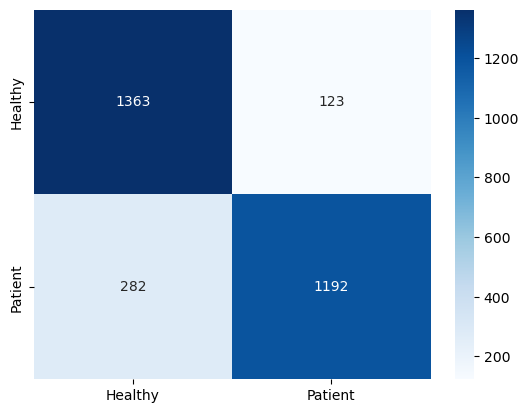

In [22]:
# Cell 13: Evaluate the Best Model on the Test Set
# Get the best model
best_svm_model = random_search.best_estimator_

y_pred = best_svm_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Patient']))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Patient'], yticklabels=['Healthy', 'Patient'])
plt.show()